# PRÁCTICA 5.5 LOCALIZACIÓN DE OBJETOS

## 0. Objetivos

* Ver un ejemplo sencillo de modelo para **localización de objetos** (paso previo a detección de objetos), con **multi-cabeza** (clasificación y regresión)
* Definir un modelo con `nn.Module`.
* Definir conjuntos de datos de forma flexible a través de  `Dataset`.
* Leer un dataset con el formato YOLO
* Definir un dataLoader con una función `collate_fn` propia.
* Convertir coordenadas de **bounding box** y uso de **tvtensor**
* Usar pérdida compuesta y métrica **IoU**

## 1. Introducción

La localización de objetos (Object Localization) es la tarea de dibujar una *caja delimitadora* (**bounding box**) que identifica la posición y el tamaño exactos de un objeto específico dentro de una imagen, respondiendo a la pregunta: "¿Dónde está X?" La localización no necesita identificar el tipo de objeto; solo necesita encontrar sus coordenadas (generalmente $x_{min}, y_{min}, x_{max}, y_{max}$). Sin embargo, en el contexto de las aplicaciones modernas, la localización casi siempre se realiza junto con la clasificación. 

Aquí es donde se conecta con la detección de objetos (**Object Detection**). La detección de objetos es la tarea compuesta que combina clasificación (identificar el tipo de objeto, ej: "perro") y localización (dibujar la caja), para **todos** los objetos detectables en una imagen. Un sistema de detección de objetos, por lo tanto, responde a la pregunta: "¿Qué son los objetos X y dónde están?". Modelos famosos como *YOLO (You Only Look Once)* o *R-CNN* son arquitecturas clave en la detección de objetos, optimizadas para realizar las tareas de localización y clasificación simultáneamente en tiempo real.

En esta práctica, vamos a construir un modelo de **Localización de Objetos** de juguete. Emplearemos un dataset pensado para object detection, pero lo modificaremos para trabajar con solo un objeto por imagen para simular la localización. La idea es familiarizarse con los conceptos de modelo no secuencial, datasets flexibles, y elementos para detección de objetos. Veremos al final que el resultado no es el esperado...

Como es usual, vamos a cargar las librerías que necesitamos en la práctica.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms.v2 as T
from torchvision import tv_tensors   
import yaml
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cuda


## 2. Dataset

Vamos a usar el dataset [**Playing Cards Object Detection Dataset**](https://www.kaggle.com/datasets/andy8744/playing-cards-object-detection-dataset), el cual es un dataset con imágenes de cartas de poker, donde se localiza el tipo de carta, es decir; la figura (As, 2, 3, .. 10, , Sota (J), Dama (Q), Rey (K)) y el palo (picas (S), tréboles (T), corazones (H) y diamantes (D)).

El dataset sigue el popular formato **YOLO**. La estructura de los datos es:
* `images/`: Contiene todas las imágenes (ej. `001.jpg`).
* `labels/`: Contiene un archivo `.txt` por cada imagen (ej. `001.txt`). Aquí tenemos una línea por cada elemento a detectar, con el formato `clase x_centro y_centro ancho alto` (normalizado entre 0 y 1). 

Y es que en YOLO, las coordenadas de los bounding boxes sigue el formato `[x_c, y_c, w, h]`: `x_c` e `y_c` indica el centro de la caja, mientras que `w` y `h` indican el ancho y la altura. Por ejemplo:

<div>
<img src="imgs/image6.png" width="500"/>
</div>
<!-- ![](imgs/image6.png) -->

Te recomiendo descargar el dataset desde Kaggle (necesitarás una cuenta gratuita). Alternativamente podrás encontrar un enlace al dataset para descargar, en enseñanza virtual del curso. Para que el código siguiente funcione, lo puedes descomprimir en la carpeta `5_modelos_vision/data/playingcards`. Al seguir el formato de YOLO, el dataset también incluye un fichero `data.yaml` con la configuración de los datos. Lo más importante para nosotros es que contiene la lista names, que mapea los id_clase (de 0 a 51) a los nombres reales de las 52 cartas (de '10c' a 'Qs'). Usaremos este archivo para cargar los nombres de las clases y asegurarnos de que nuestro modelo se entrena para predecir las 52 cartas correctas.



In [3]:
# Parámetros globales
IMG_SIZE = 224
BATCH_SIZE = 16
LEARNING_RATE = 1e-4

# Rutas al dataset (ajusta si es necesario)
DATASET_DIR = './data/playingcards/'
TRAIN_IMG_DIR = DATASET_DIR+'./train/images/'
TRAIN_LABEL_DIR = DATASET_DIR+'./train/labels/'
VAL_IMG_DIR = DATASET_DIR+'./valid/images/'
VAL_LABEL_DIR = DATASET_DIR+'./valid/labels/'

# PAra definir esta función necesitarás PyYAML instalado
def load_yaml_config(yaml_path):
    # Carga la configuración del dataset desde un archivo YAML.
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    
    # Extraer la lista de nombres de clases
    class_names = config['names']
    
    # Obtener el número de clases
    num_classes = config['nc']
    
    return num_classes, class_names

# Ruta a tu fichero .yaml (ajusta si está en otra carpeta)
YAML_PATH = DATASET_DIR+'./data.yaml'

NUM_CLASSES, idx_to_class = load_yaml_config(YAML_PATH)

print(f"Trabajando con {NUM_CLASSES} clases.")

Trabajando con 52 clases.


## 3. Clase `Dataset` Personalizada 

Hasta ahora en el curso hemos creado datasets personalizados, desde tensores y desde directorios de imágenes. Ahora vamos a ver una forma más flexible que tiene PyTorch para poder definir datasets con total libertad, y es mediante la clase abstracta `torch.utils.data.Dataset`. Su propósito fundamental es almacenar las muestras y sus etiquetas correspondientes, y definir cómo acceder a ellas. Al heredar de esta clase, estás creando un administrador de datos personalizado que se integrará perfectamente con el ecosistema de entrenamiento de PyTorch, especialmente con el DataLoader. En esta herencia es obligatorio sobrescribir tres métodos clave: __init__, __len__, y __getitem__.

1. **Inicialización** (`__init__`): El método constructor es donde se realiza la preparación del conjunto de datos. En lugar de cargar todas las imágenes y etiquetas en memoria (lo cual es inviable para conjuntos grandes), se suele utilizar para escanear el dataset y quedarnos con nombres de archivos, almacenar una tabla, etc.
2. **Tamaño del Conjunto** (`__len__`): Simplemente debe devolver la cantidad total de muestras disponibles en el Dataset.
3. **Obtención de Muestras** (`__getitem__`): Este es el corazón del Dataset. Se invoca con un índice (`idx`) y su responsabilidad es cargar, preprocesar y devolver la pareja (muestra, etiqueta) correspondiente al índice `idx`. Aquí es donde tenemos total libertad para programar dónde está cada elemento (fichero en un directorio, elemento de una tabla, etc.).

Para nuestro caso, haremos los siguiente:
- `__init__`: Escanea `img_dir` y guarda una lista de todas las rutas a las imágenes.
- `__len__`: Devuelve la cantidad de imágenes encontradas.
- `__getitem__`: 
  1. Obtiene una ruta de imagen (ej. `.../train/images/001.jpg`).
  2. Carga la imagen.
  3. Deduce la ruta del label (ej. `.../train/labels/001.txt`).
  4. Abre el `.txt`, lee **solo la primera línea**. Esto lo hacemos porque vamos a trabajar con localización, no detección. Así "simulamos" un dataset de localización.
  5. Parsea los 5 números.
  6. Escala las coordenadas al tamaño de la imagen.
  7. Devuelve la imagen y el `target` (combinación de la clase y el bounding box).

In [ ]:
class YOLOLocalizationDataset(Dataset):
    def __init__(self, img_dir, label_dir):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.image_files = sorted(glob.glob(os.path.join(img_dir, '*.jpg')))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Obtener la ruta de la imagen
        img_path = self.image_files[idx]
        
        # Cargar la imagen
        image = Image.open(img_path).convert('RGB')
        
        # Obtenemos el tamaño (width, height)
        original_width, original_height = image.size 
        
        # Deducir la ruta del label
        img_filename = os.path.basename(img_path)
        label_filename = os.path.splitext(img_filename)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_filename)
        
        with open(label_path, 'r') as f:
            line = f.readline().strip()
        
        parts = line.split(' ')
        class_id = int(parts[0])
        # Coordenadas YOLO normalizadas [xc_norm, yc_norm, w_norm, h_norm]
        bbox_pixels_cxcywh = [float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])]
        
        # 7. Crear el diccionario 'target'
        target = {
            "labels": torch.tensor([class_id], dtype=torch.long),
            
            "boxes": tv_tensors.BoundingBoxes(
                torch.tensor(bbox_pixels_cxcywh).unsqueeze(0), # [1, 4]
                format=tv_tensors.BoundingBoxFormat.CXCYWH,
                # Especificar el canvas_size correcto (height, width)
                canvas_size=(original_height, original_width) 
            )
        }
        
        # Devolvemos la IMAGEN PIL y el diccionario target
        return image, target

En el código anterior habrás visto que hemos creado un tensor especial: `tv_tensors`. En el ecosistema de PyTorch y Torchvision (v2), `tv_tensor` (de la familia `torchvision.tv_tensors`) es una clase base para subclases de `torch.Tensor` que transportan metadatos específicos del dominio de visión por computador. Estos metadatos les dan "conciencia" del tipo de dato que contienen, haciendo que las transformaciones (como voltear o redimensionar una imagen) se apliquen correctamente no solo al tensor de píxeles, sino también a sus coordenadas asociadas. El `BoundingBoxes` es una de estas subclases especializadas (es decir, es una subclase de `tv_tensors`, que a su vez es una subclase de `Tensor`), diseñada para representar las coordenadas de las cajas delimitadoras que marcan la ubicación de los objetos en una imagen. Al usar `BoundingBoxes`, especificas el formato de las coordenadas (como XYXY para $x_{min}, y_{min}, x_{max}, y_{max}$) y el tamaño del lienzo (canvas_size). Esto asegura que cuando se aplica una transformación a la imagen, el objeto BoundingBoxes ajusta automáticamente sus coordenadas para que sigan rodeando correctamente al objeto en la imagen transformada. Esto es muy útil como veremos a continuación.

In [35]:
# Este dataset ya viene dividido en 'train' y 'valid'
train_dataset = YOLOLocalizationDataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR)
val_dataset = YOLOLocalizationDataset(VAL_IMG_DIR, VAL_LABEL_DIR)

print(f"Muestras de entrenamiento: {len(train_dataset)}")
print(f"Muestras de validación: {len(val_dataset)}")

Muestras de entrenamiento: 14000
Muestras de validación: 4000


Veamos una imagen y su etiqueta cargada (recuerda, originalmente hay más, pero nosotros solo cargamos una):

Imagen original de (416, 416)


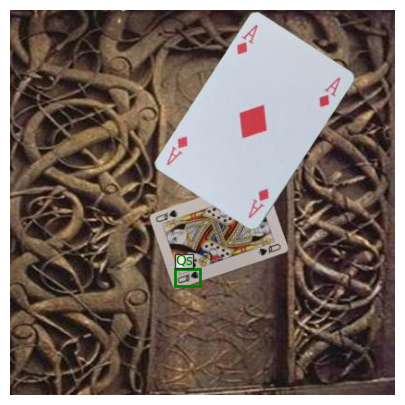

In [ ]:
# Veamos la primera imagen
img = train_dataset[0][0]
label = train_dataset[0][1]['labels']
bbox = train_dataset[0][1]['boxes'].squeeze()

_, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.imshow(img)

# Nombres de las clases
label_name = idx_to_class[label.item()]

w,h = img.size 

# Leer coordenadas
xc_n, yc_n, w_n, h_n = bbox 
xc_p, yc_p, w_p, h_p = xc_n * w, yc_n * h, w_n * w, h_n * h

# Calcular la esquina (x_min, y_min) para matplotlib
x_min_p = xc_p - w_p / 2
y_min_p = yc_p - h_p / 2

rect_true = patches.Rectangle(
    (x_min_p, y_min_p), w_p, h_p, linewidth=2, edgecolor='g', facecolor='none'
)
ax.add_patch(rect_true)
ax.text(x_min_p, y_min_p - 5, f'{label_name}', color='g', 
        bbox=dict(facecolor='white', alpha=0.7, pad=0))

ax.axis(False)
print(f"Imagen original de {img.size}")

## 4. DataLoader

Ahora necesitamos definir nuestro DataLoader. Para ello debemos indicar cómo construir los batches. Aquí es también donde aplicamos las transformaciones necesarias para preparar los datos previo a ser introducidos a la red neuronal: normalizar, transformar a tensor, etc. Esto se hace definiendo la función *`collate_fn`*, que recibirá una lista de pares (elementos muestreados de nuestro dataset) y devolveremos el tensor ya preparado para ser enviado a la red neuronal.

También vamos a aplicar las transformaciones necesarias a las imágenes para ser preparadas e incluidas al modelo. El modelo que usaremos será ResNet18, pre-entrenado sobre ImageNet, por lo que las transformaciones las conocemos. Lo importante aquí es que las transformaciones que modifican la forma de la imagen, como porejemplo el `Resize`, también deberían ser aplicadas al bounding box. Esto se hace gracias a usar la versión 2 de `Transformations`, donde podemos pasar no solo una imagen, sino también cualquier otro objeto que contenga el BoundingBox, aplicando así las transformaciones a ambos para mantener la coherencia. Además, podemos aplicar transformaciones al bounding box, comoa aquí, que pasamos a XYXY.

In [ ]:
transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    # T.v2.RandomHorizontalFlip(p=0.5), # ¡Así se podría aplicar data augmentation, pero no lo haremos aquí
    T.ToImage(), # Convierte PIL a Tensor
    T.ToDtype(torch.float32, scale=True), # Escala a [0, 1]
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.ConvertBoundingBoxFormat('XYXY')
])

def collate_fn(batch):
    images = []
    labels = []
    bboxes = []

    for (img, target) in batch:
        # transform debe ser de torchvision.transforms.v2 (aceptar image, target)
        img, target = transform(img, target)

        images.append(img)
        labels.append(target['labels'])
        bboxes.append(target['boxes'])  # lista de BoundingBoxes

    # Devolvemos los tensores a ser introducidos al modelo
    images = torch.stack(images)
    labels = torch.cat(labels)
    bboxes = torch.cat(bboxes)

    return images, labels, bboxes


Y ahora ya podemos instanciar los DataLoaders.

In [37]:

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn, # nuestro creador de batches
    num_workers=2 # para ir más rápido en la carga de datos, puedes probar a subirlo
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=2 
)


## 5. El Modelo de Localización (Dos Cabezas)

Para definir un modelo de localización, debemos tener claro su entrada (una imagen) y sus salidas (una clase y un bounding box). Necesitamos por tanto hacer un modelo **no secuencial**, que tenga una bifurcación al final para devolver dos tensores. Esto no lo podemos hacer con `nn.Sequential`, por lo que vamos a usar la forma más flexible, y a su vez, la más empleada en PyTorch para definir modelos. Esto es con la clase **`torch.nn.Module`**, que ya llegamos a utilizar en una práctica 5.2. Ésta es la forma estándar y más poderosa de definir cualquier modelo o capa en PyTorch. 

Veamos primero la forma que tiene ResNet18, especialmente su clasificador, ya que éste será reemplazado por uno nuevo. 

**Ejercicio:** Descarga los pesos y el modelo de ResNet18

In [ ]:
# Descarga los pesos y el modelo ResNet18
weights = FIXME
base_model = FIXME
print(base_model)

In [ ]:
# Solución
weights = ResNet18_Weights.DEFAULT
base_model = resnet18(weights=weights)
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

En este caso, vamos a definir el modelo de la siguiente forma:
* Constructor `__init__`: descargamos el modelo ResNet18 pre-entrenado sobre ImageNet, y extraemos sus características. Creamos las dos cabezas y las unimos.
* Método `forward`: indica cómo los datos van saliendo y entrando por las partes de la red.

In [ ]:
class LocalizationModel(nn.Module):
    def __init__(self, num_classes):
        super(LocalizationModel, self).__init__()
        
        # Descargamos el modelo ResNet18 y lo guardamos
        weights = ResNet18_Weights.DEFAULT
        base_model = resnet18(weights=weights)
        
        # Esta línea sacamos todas las capas de ResNet18 menos la última
        self.features = nn.Sequential(*list(base_model.children())[:-1])

        # Podemos congelar los pesos, pero en esta práctica no lo haremos
        # ya que estamos usando un learning rate bajo y AdamW
        # for param in self.features.parameters():
        #     param.requires_grad = False
        
        # Cabeza de Clasificación
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, num_classes) # 512 features de ResNet18
        )
        
        # Cabeza de Regresión (Bounding Box)
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4),   # 4 valores: xmin, ymin, xmax, ymax
            nn.Sigmoid()         # Salida en [0, 1]
        )

    def forward(self, x):
        x = self.features(x) #extracción de características
        class_pred = self.classifier(x) # al clasificador
        bbox_pred = self.regressor(x)   # al regresor de cajas
        return class_pred, bbox_pred

In [60]:
# Instanciar el modelo
model = LocalizationModel(num_classes=NUM_CLASSES).to(device)
print(model)

LocalizationModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

## 6. Bucle de Entrenamiento

Para el entrenamiento vamos a tener en cuenta varias cosas:
* Vamos a tener una función de pérdida que será la combinación de las dos cabezas. Para el clasificador usaremos cross entropy, y para el regresor usaremos el MAE (calculado con L1Loss). La combinación viene ponderada con un peso para la pérdida en el bounding box. 
* Como optimizador usaremos AdamW, que es una variante moderna de Adam que soluciona varios problemas con modelos grandes.
* El resto del bucle de entrenamiento queda muy parecido o idéntico a lo que hemos visto.
* Usaremos también otra métrica comúnmente conocida en la detección de objetos, para saber cómo de bueno está siendo el bounding box. Esta métrica es el **IOU (Intersection over Union)**.

La métrica IoU (Intersection over Union) qué tan bien se superponen la caja predicha y la caja real. Un IoU de 1.0 es una superposición perfecta. Usaremos la función de PyTorch (`torchvision.ops.box_iou`).

![](imgs/iou.png)

In [62]:
from torchvision.ops import box_iou

# Funciones de pérdida
class_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.L1Loss() # Mean Absolute Error (robusto)

# Optimizador
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

bbox_loss_weight = 1.0 

print("Iniciando entrenamiento...")

NUM_EPOCHS=10

for epoch in range(NUM_EPOCHS):
    
    # --- Fase de Entrenamiento ---
    model.train()
    total_train_loss = 0
    
    for images, true_labels, true_bboxes in train_loader:
        images = images.to(device)
        true_labels = true_labels.to(device)
        true_bboxes = true_bboxes.to(device)

        # El modelo devuelve dos salidas
        pred_labels, pred_bboxes = model(images)
        
        # Pérdida combinada
        loss_class = class_loss_fn(pred_labels, true_labels)
        loss_bbox = bbox_loss_fn(pred_bboxes, true_bboxes)        
        total_loss = loss_class + (bbox_loss_weight * loss_bbox)
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        total_train_loss += total_loss.item()
        
    avg_train_loss = total_train_loss / len(train_loader)
    
    # --- Fase de Validación ---
    model.eval()
    total_val_loss = 0
    correct_class = 0
    total_samples = 0
    total_val_iou = 0
    
    with torch.no_grad():
        for images, true_labels, true_bboxes in val_loader:
            images = images.to(device)
            true_labels = true_labels.to(device)
            true_bboxes = true_bboxes.to(device)
            
            pred_labels, pred_bboxes = model(images)
            
            loss_class = class_loss_fn(pred_labels, true_labels)
            loss_bbox = bbox_loss_fn(pred_bboxes, true_bboxes)
            total_loss = loss_class + (bbox_loss_weight * loss_bbox)
            
            total_val_loss += total_loss.item()
            
            # Equivalente a hacer argmax
            _, predicted_indices = torch.max(pred_labels, 1)
            correct_class += (predicted_indices == true_labels).sum().item()
            total_samples += true_labels.size(0)

            # Calcular el IoU
            # box_iou devuelve una matriz. Queremos la diagonal,
            # que compara la predicción_i con la verdad_i
            iou_scores = torch.diag(box_iou(pred_bboxes, true_bboxes))
            
            # Sumar el promedio de IoU de este lote
            total_val_iou += iou_scores.mean().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = (correct_class / total_samples) * 100
    avg_val_iou = total_val_iou / len(val_loader)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.2f}% | "
          f"Val IoU: {avg_val_iou:.4f}")

print("Entrenamiento finalizado.")


Iniciando entrenamiento...
Epoch 1/10 | Train Loss: 3.5184 | Val Loss: 2.8078 | Val Acc: 20.20% | Val IoU: 0.0083
Epoch 2/10 | Train Loss: 2.3710 | Val Loss: 2.2570 | Val Acc: 31.97% | Val IoU: 0.0280
Epoch 3/10 | Train Loss: 1.5801 | Val Loss: 2.1698 | Val Acc: 36.05% | Val IoU: 0.0343
Epoch 4/10 | Train Loss: 0.9638 | Val Loss: 2.0484 | Val Acc: 41.88% | Val IoU: 0.0420
Epoch 5/10 | Train Loss: 0.5531 | Val Loss: 2.1988 | Val Acc: 41.73% | Val IoU: 0.0530
Epoch 6/10 | Train Loss: 0.2918 | Val Loss: 2.3726 | Val Acc: 41.70% | Val IoU: 0.0395
Epoch 7/10 | Train Loss: 0.2212 | Val Loss: 2.3102 | Val Acc: 44.22% | Val IoU: 0.0443
Epoch 8/10 | Train Loss: 0.1785 | Val Loss: 2.6347 | Val Acc: 41.42% | Val IoU: 0.0545
Epoch 9/10 | Train Loss: 0.1863 | Val Loss: 2.6049 | Val Acc: 42.35% | Val IoU: 0.0553
Epoch 10/10 | Train Loss: 0.1850 | Val Loss: 2.6156 | Val Acc: 42.20% | Val IoU: 0.0529
Entrenamiento finalizado.


## 7. Visualización de Resultados

Vemos que durante el entrenamiento, el accuracy y el IoU mejoraron pero no ha llegado a tener unas cotas altas. Visualicemos algunas imágenes para ver qué obtenemos, tanto el ground truth (el bounding box real) y el predicho por el modelo.

Visualizando predicciones de validación (corregido)...


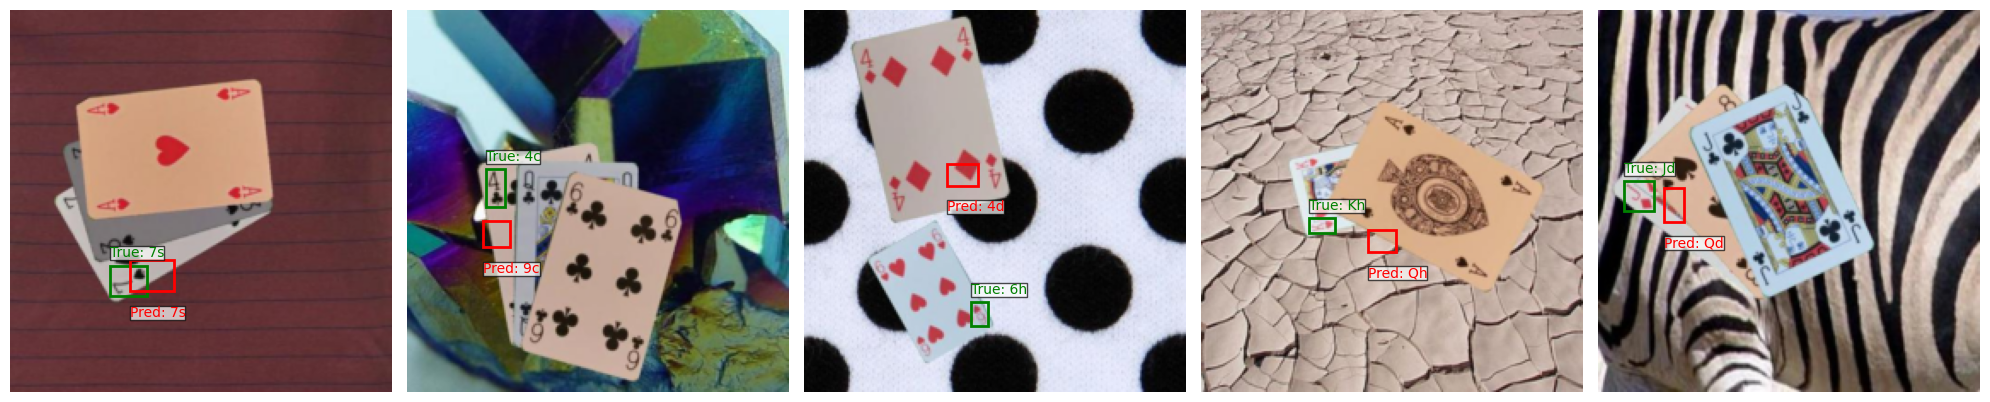

In [90]:
# Función para desnormalizar la imagen (inversa a lo que hicimos antes)
inv_normalize = T.Compose([ 
    T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
])

def visualize_predictions(model, loader, idx_to_class_map, num_images=5):
    model.eval()

    # Obtener batch
    images, true_labels, true_bboxes = next(iter(loader))    
       
    # Inferencia
    with torch.no_grad():
        pred_labels, pred_bboxes = model(images.to(device))
        
    # images = images.cpu()
    # true_labels = true_labels.cpu()
    # true_bboxes = true_bboxes.cpu()
    pred_labels = pred_labels.cpu()
    pred_bboxes = pred_bboxes.cpu()    
    _, pred_indices = torch.max(pred_labels, 1)

    num_images = min(images.size(0),num_images)  #como mucho hacemos un batch

    _, axes = plt.subplots(1, num_images, figsize=(20, 5))
    if num_images == 1:
        axes = [axes] 
    
    for i in range(num_images):
        img = inv_normalize(images[i])
        img = img.permute(1, 2, 0)        

        ax = axes[i]
        ax.imshow(img)
        
        # Nombres de las clases
        true_label_name = idx_to_class_map[true_labels[i].item()]
        pred_label_name = idx_to_class_map[pred_indices[i].item()]

        # Bounding Box REAL (Verde)
        # true_bboxes[i] es [xmin, ymin, xmax, ymax] normalizado [0, 1]
        x_min_n, y_min_n, x_max_n, y_max_n = true_bboxes[i]
        
        # Convertir a píxeles
        # Hay que tener en cuenta que la imagen originalmente era de 416, y luego se re-escaló a 224
        # por tanto hay que aplicar el ajuste de 416/224 = 1.85
        w = 1.85*IMG_SIZE
        x_min_p, y_min_p, x_max_p, y_max_p = x_min_n*w, y_min_n*w, x_max_n*w, y_max_n*w

        # Calcular ancho y alto en píxeles
        w_p = x_max_p - x_min_p
        h_p = y_max_p - y_min_p
        
        rect_true = patches.Rectangle(
            (x_min_p, y_min_p), w_p, h_p, linewidth=2, edgecolor='g', facecolor='none'
        )
        ax.add_patch(rect_true)
        ax.text(x_min_p, y_min_p - 5, f'True: {true_label_name}', color='g', 
                bbox=dict(facecolor='white', alpha=0.7, pad=0))


        # Bounding Box PREDICHO (Rojo)
        # pred_bboxes[i] es [xmin, ymin, xmax, ymax] normalizado [0, 1]
        x_min_n, y_min_n, x_max_n, y_max_n = pred_bboxes[i]
        
        # Convertir a píxeles        
        x_min_p, y_min_p, x_max_p, y_max_p = x_min_n * w, y_min_n * w, x_max_n * w, y_max_n * w

        # Calcular ancho y alto en píxeles
        w_p = x_max_p - x_min_p
        h_p = y_max_p - y_min_p
        
        rect_pred = patches.Rectangle(
            (x_min_p, y_min_p), w_p, h_p, linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect_pred)
        ax.text(x_min_p, y_min_p + h_p + 15, f'Pred: {pred_label_name}', color='r',
                bbox=dict(facecolor='white', alpha=0.7, pad=0))
        
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

# Visualizar en el set de validación (ahora debería funcionar)
print("Visualizando predicciones de validación (corregido)...")
visualize_predictions(model, val_loader, idx_to_class)

## 8. Conclusión de la Práctica y bibliografía

Vemos que el modelo no tiene un mal rendimiento clasificando, pero a la hora de poner la bounding box, es bastante malo (el IoU se aleja bastante de 1). Algo estamos haciendo mal...

El reto clave de este dataset es que la mayoría de las imágenes contienen múltiples objetos (varias cartas), a menudo solapados. Por tanto, **intentar entrenar un modelo de localización** (que solo puede predecir una caja) **fracasa**, ya que el modelo no sabe qué objeto priorizar y recibe señales contradictorias. Este dataset, por tanto, es el ejemplo perfecto para demostrar la necesidad de un modelo de detección de objetos. Acabamos de ver la limitiación de los modelos de localización, y un fallo de diseño que hemos tenido desde el comienzo. Pero no te preocupes, en este camino hemos aprendido muchas cosas, algunas de ellas muy importantes:
* Crear datasets con `Dataset`, es el método más común para datasets descargados.
* Crear modelos con `nn.Module`, que es la forma más común en PyTorch.
* Crear modelos no secuenciales
* Cargar un dataset preparado para YOLO
* Usar el IoU
* Trabajar con `tv_tensor` y `BoundingBoxes`

Bibliografía:
* Hands-On Machine Learning with Scikit-Learn and PyTorch, [Capítulo 12](https://github.com/ageron/handson-mlp/blob/main/12_deep_computer_vision_with_cnns.ipynb). A. Geron.
* [Having Fun with YÖLOv8: How Good Your Model in Detecting Playing Card?](https://medium.com/@sdwiulfah/having-fun-with-yolov8-how-good-your-model-in-detecting-playing-card-a468a02e4775). S.D. Ulfah.